In [8]:

from transformers import pipeline
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# 첫 번째 셀: 데이터 다운로드
import pandas as pd
from datasets import load_dataset
import os

print("Downloading IMDb dataset...")
dataset = load_dataset("imdb", split="test[:100]")
df = pd.DataFrame(dataset)
df = df[['text', 'label']]

if not os.path.exists("../data"): # notebooks 폴더 안에 있으니 상위 폴더로 나가서 data 찾기
    os.makedirs("../data")
    
df.to_csv("../data/imdb_sample.csv", index=False)
print("Success! Data saved.")
df.head()

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Success! Data saved.


,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


In [13]:

# 1. Load Data
df = pd.read_csv("../data/imdb_sample.csv")
print(f"Loaded {len(df)} reviews.")

# 2. Load Sentiment Analysis Model
# Using a pre-trained DistilBERT model fine-tuned for sentiment analysis
print("Loading Sentiment Analysis Model...")
analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# 3. Define Function to Calculate Quality Scores
def get_quality_scores(texts):
    """
    Analyzes sentiment of texts and returns scores between 0 and 1.
    POSITIVE sentiment -> Score close to 1.0
    NEGATIVE sentiment -> Score close to 0.0
    These scores will serve as the 'True Quality' in our simulation.
    """
    scores = []
    print("Calculating Quality Scores...")
    
    # Analyze texts (truncation=True, 너무길면 자름)
    results = analyzer(texts, truncation=True, batch_size=16)
    
    for res in results:
        # Convert model output to a single continuous score (0 to 1)
        score = res['score'] if res['label'] == 'POSITIVE' else 1 - res['score']
        scores.append(score)
        
    return np.array(scores)

# 4. Execute Calculation
# Convert pandas series to list for processing
quality_scores = get_quality_scores(list(df['text']))

# 5. Add to DataFrame and Inspect
df['true_quality'] = quality_scores

print("\n--- Scoring Complete! Preview of Top 5 ---")
display(df[['text', 'label', 'true_quality']].head())

Loaded 100 reviews.
Loading Sentiment Analysis Model...


Device set to use mps:0


Calculating Quality Scores...

--- Scoring Complete! Preview of Top 5 ---


,text,label,true_quality
0,I love sci-fi and am willing to put up with a ...,0,0.000384
1,"Worth the entertainment value of a rental, esp...",0,0.382936
2,its a totally average film with a few semi-alr...,0,0.000290
3,STAR RATING: ***** Saturday Night **** Friday ...,0,0.004244
4,"First off let me say, If you haven't enjoyed a...",0,0.996307


In [10]:

def correct_quality_scores(row):
    """
    Corrects the NLP score based on the ground truth label.
    If Label is 0 (Negative) but NLP score is high (>0.5), we flip it.
    This ensures our 'True Quality' aligns with reality.
    """
    nlp_score = row['true_quality']
    label = row['label']
    
    # Correction Logic:
    # If Label is 0 (Negative), quality should be low.
    # If Label is 1 (Positive), quality should be high.
    
    if label == 0 and nlp_score > 0.5:
        # Model made a mistake! Flip the score (e.g., 0.9 -> 0.1)
        return 1 - nlp_score
    elif label == 1 and nlp_score < 0.5:
        # Model made a mistake! Flip the score
        return 1 - nlp_score
    else:
        # Model was correct
        return nlp_score

# Apply correction
print("Correcting scores based on Ground Truth labels...")
df['true_quality_corrected'] = df.apply(correct_quality_scores, axis=1)

# Check the problematic row again (Row 4)
print("\n--- After Correction (Row 4) ---")
display(df.loc[[4]][['text', 'label', 'true_quality', 'true_quality_corrected']])

# Update the main variable for simulation
true_quality_scores = df['true_quality_corrected'].values

Correcting scores based on Ground Truth labels...

--- After Correction (Row 4) ---


,text,label,true_quality,true_quality_corrected
4,"First off let me say, If you haven't enjoyed a...",0,0.996307,0.003693


In [11]:

class FeedbackLoopSimulator:
    """
    Simulates a recommendation system with a feedback loop.
    It compares two modes: 'Naive' (Rich-get-richer) vs 'Fair' (Dynamic Weighting).
    """
    
    def __init__(self, true_quality, alpha=0.1):
        self.n_items = len(true_quality)
        self.true_quality = np.array(true_quality)
        self.alpha = alpha  # Strength of the feedback loop (Rich-get-richer effect)
        
        # Initialize state variables
        self.exposure_count = np.zeros(self.n_items) # How many times each item was shown
        self.history = [] # To store exposure history for visualization

    def reset(self):
        """Resets the simulation state."""
        self.exposure_count = np.zeros(self.n_items)
        self.history = []

    def step(self, mode='naive', top_k=5):
        """
        Executes one time step of the simulation.
        1. Calculate Ranking Score
        2. Select Top-K items
        3. Update Exposure (Feedback)
        """
        
        # --- A. Ranking Score Calculation ---
        if mode == 'naive':
            # Naive Algorithm: Score = Quality + Popularity (Exposure)
            # Items seen more often get a higher score, regardless of true quality.
            score = self.true_quality + (self.alpha * self.exposure_count)
            
        elif mode == 'fair':
            # Fair Algorithm (Intervention): Dynamic Weighting
            # Goal: Cumulative exposure should be proportional to true quality.
            
            # Calculate total exposure distributed so far
            current_total_exposure = np.sum(self.exposure_count) + 1 # +1 to avoid division by zero
            
            # Target Exposure: How much attention SHOULD this item have received?
            # (Proportional to its quality)
            target_exposure = (self.true_quality / np.sum(self.true_quality)) * current_total_exposure
            
            # Deficit: Difference between target and actual exposure
            deficit = target_exposure - self.exposure_count
            
            # Intervention: Boost score based on deficit
            # If deficit is positive (under-exposed), score increases.
            # Lambda (2.0) determines the strength of the correction.
            score = self.true_quality + (deficit * 2.0) 

        # --- B. Select Top-K (Exposure) ---
        # Add small random noise to break ties and simulate real-world uncertainty
        noisy_score = score + np.random.normal(0, 0.01, self.n_items)
        
        # Get indices of top-k items
        top_indices = np.argsort(noisy_score)[::-1][:top_k]
        
        # --- C. Feedback Loop ---
        # Only the top-k items get exposure (and potential clicks)
        self.exposure_count[top_indices] += 1
        
        # Record history
        self.history.append(self.exposure_count.copy())

    def run(self, steps=200, mode='naive', top_k=5):
        """Runs the simulation for a specified number of steps."""
        self.reset()
        for _ in range(steps):
            self.step(mode=mode, top_k=top_k)
        return np.array(self.history)



Running Naive Simulation...
Running Fair Simulation (with Intervention)...

--- Simulation Complete. Visualizing Results ---


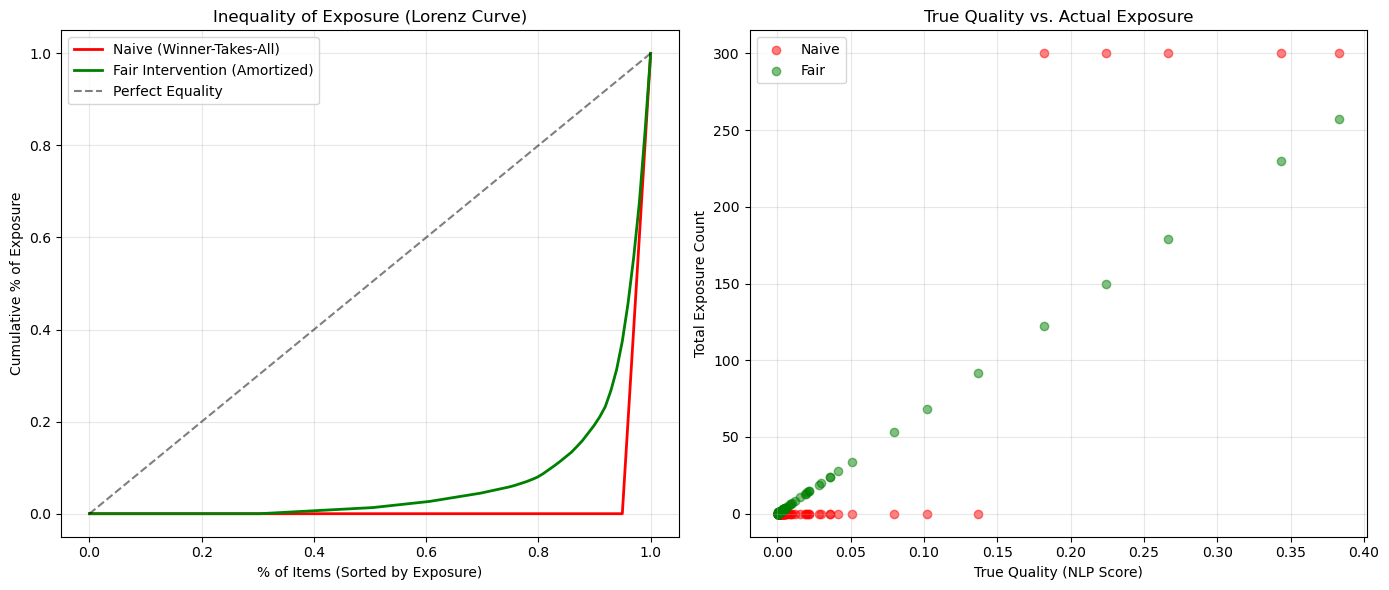

In [12]:
# --- 1. Initialize Simulator ---
# Use the corrected scores from previous step
# (Make sure 'true_quality_scores' variable is ready from df['true_quality_corrected'])
true_quality_scores = df['true_quality_corrected'].values 

sim = FeedbackLoopSimulator(true_quality_scores, alpha=0.5) # alpha: Rich-get-richer strength

# --- 2. Run Simulation (Naive vs Fair) ---
print("Running Naive Simulation...")
naive_history = sim.run(steps=300, mode='naive', top_k=5)
naive_final_exposure = sim.exposure_count.copy()

print("Running Fair Simulation (with Intervention)...")
fair_history = sim.run(steps=300, mode='fair', top_k=5)
fair_final_exposure = sim.exposure_count.copy()

# --- 3. Visualization ---
def plot_comparison(naive_exp, fair_exp):
    # Sort data for Lorenz Curve
    naive_sorted = np.sort(naive_exp)
    fair_sorted = np.sort(fair_exp)
    
    # Calculate Cumulative Sum (Lorenz)
    naive_cum = np.cumsum(naive_sorted) / np.sum(naive_sorted)
    fair_cum = np.cumsum(fair_sorted) / np.sum(fair_sorted)
    x_axis = np.linspace(0, 1, len(naive_cum))
    
    # Plot 1: Lorenz Curve (Inequality)
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(x_axis, naive_cum, label='Naive (Winner-Takes-All)', color='red', linewidth=2)
    plt.plot(x_axis, fair_cum, label='Fair Intervention (Amortized)', color='green', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Equality', alpha=0.5)
    plt.title("Inequality of Exposure (Lorenz Curve)")
    plt.xlabel("% of Items (Sorted by Exposure)")
    plt.ylabel("Cumulative % of Exposure")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Exposure vs True Quality (Correlation)
    # Did high quality items actually get more exposure?
    plt.subplot(1, 2, 2)
    plt.scatter(true_quality_scores, naive_exp, color='red', alpha=0.5, label='Naive')
    plt.scatter(true_quality_scores, fair_exp, color='green', alpha=0.5, label='Fair')
    plt.title("True Quality vs. Actual Exposure")
    plt.xlabel("True Quality (NLP Score)")
    plt.ylabel("Total Exposure Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n--- Simulation Complete. Visualizing Results ---")
plot_comparison(naive_final_exposure, fair_final_exposure)